In [1]:
import networkx as nx
import numpy as np
import pandas as pd 
import operator
import matplotlib.pyplot as plt
import random

In [2]:
nx_graphs = []
agg_graph = nx.MultiGraph()
venue_df_list = []
for i in range(31):
    # with open(f'..\ATX_Networks\sim_day_{i+1}.gexf') as graph_file:
    nx_graphs.append(nx.read_gexf(f'..\ATX_Networks\sim_day_{i+1}.gexf'))
    df = nx.to_pandas_edgelist(nx_graphs[i],source="Source",target="Target")
    df['day'] = i
    venue_df_list.append(df)

concat_venue_df = pd.concat(venue_df_list)
# concat_venue_df.columns = ['source','target','venueid']
concat_venue_df.head()

,Source,Target,time_spent,visits,hour,venueid,id,day
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,976,18,2,440da2cbf964a52091301fe3,0,0
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,100,2,2,440da2cbf964a52091301fe3,1,0
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,14,2,4,440da2cbf964a52091301fe3,2,0
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,148,3,5,440da2cbf964a52091301fe3,3,0
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,526,9,5,440da2cbf964a52091301fe3,4,0


In [3]:
places_df = pd.read_csv("../RVF_ATX_PID_HZ_Places_Lookup.tsv",delimiter='\t')
merged_df = concat_venue_df.merge(places_df, on='venueid')
merged_df.head()

,Source,Target,time_spent,visits,hour,venueid,id,day,venuename,address,...,level1cat,level2catId,level2cat,level3catId,level3cat,chainid,chainname,parentvenueid,zip,sample
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,976,18,2,440da2cbf964a52091301fe3,0,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,100,2,2,440da2cbf964a52091301fe3,1,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,14,2,4,440da2cbf964a52091301fe3,2,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,148,3,5,440da2cbf964a52091301fe3,3,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,526,9,5,440da2cbf964a52091301fe3,4,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all


In [4]:
#preprocessing to encode 
source_set = set(merged_df['Source'].unique())
target_set = set(merged_df['Target'].unique())
node_set = source_set.union(target_set)

In [5]:
size = len(node_set)
node_encodings = np.arange(size)
node_list = list(node_set)

In [6]:
neg_df = pd.read_csv("neg_samples_180000.csv")
features_df_neg = neg_df.copy()[["Source","Target","venueid","hour","time_spent","visits"]]
features_df_neg = features_df_neg.astype({"hour":"int32","visits":"int32","time_spent":"int32"})
features_df_neg = features_df_neg.merge(places_df[['level1cat','venueid']], on='venueid')
features_df_neg.head()

,Source,Target,venueid,hour,time_spent,visits,level1cat
0,4ed23ffbfe4a8997f5172d7d2da88b7b75357e4c21af6f...,d8e4658adb2cd20d208eb6f089e4c482bf7ec7fa084ea9...,4b8ab9c1f964a520a67c32e3,3,2062,25,Shops & Services
1,cf0b83f6cde68d475abb3d82ed316273ed0856e30ce1ef...,f9e5bde0ec17235ca5e921717b57bc0ede0344fe8760d3...,4b8ab9c1f964a520a67c32e3,23,3325,29,Shops & Services
2,c02f1f8e75c424098241774603eea52222d5b7d4d60c5d...,33283de883dfbbc53475b9dab3dec4a6cb35de0e8ea14d...,4b8ab9c1f964a520a67c32e3,23,189,41,Shops & Services
3,15cf3f776ad9e4dbccb533242c58b53fc61ef384f5ea5d...,113b3c657ecd221fb4cbbb5b4b02f0c1b128b33862fa29...,4b8ab9c1f964a520a67c32e3,14,2073,22,Shops & Services
4,c58106b1ca52af9eed41cf74b5f76299bc5210076f5831...,21d4302b1c13e01be5e9a10c55a7cb39b8fe0332e68c04...,4b8ab9c1f964a520a67c32e3,22,337,57,Shops & Services


In [7]:
features_df_pos = merged_df.copy()[["Source","Target","venueid","hour","time_spent","visits","day"]]
features_df_pos = features_df_pos.merge(places_df[['level1cat','venueid']], on='venueid')
features_df_pos.head()

,Source,Target,venueid,hour,time_spent,visits,day,level1cat
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,440da2cbf964a52091301fe3,2,976,18,0,Travel & Transport
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,440da2cbf964a52091301fe3,2,100,2,0,Travel & Transport
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,440da2cbf964a52091301fe3,4,14,2,0,Travel & Transport
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,440da2cbf964a52091301fe3,5,148,3,0,Travel & Transport
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,440da2cbf964a52091301fe3,5,526,9,0,Travel & Transport


In [8]:
node_encoding_df = pd.DataFrame({'Node':node_list,'Source_Encoding':node_encodings})
encoded_df = features_df_pos.merge(node_encoding_df, left_on='Source',right_on='Node', how='left')
node_encoding_df = pd.DataFrame({'Node':node_list,'Target_Encoding':node_encodings})
encoded_df = encoded_df.merge(node_encoding_df, left_on='Target',right_on='Node', how ='left')
encoded_df_pos = encoded_df.drop(['Node_x','Node_y'],axis=1)
#preserve temporal day order by sorting on day
encoded_df_pos = encoded_df_pos.sort_values(by='day').reset_index(drop=True)
#impose source<target ordering to address source-target target-source duplicates
encoded_df_pos.loc[encoded_df_pos['Source_Encoding']>encoded_df_pos['Target_Encoding'],['Source_Encoding','Target_Encoding']] = encoded_df_pos.loc[encoded_df_pos['Source_Encoding']>encoded_df_pos['Target_Encoding'],['Target_Encoding','Source_Encoding']].values

node_encoding_df = pd.DataFrame({'Node':node_list,'Source_Encoding':node_encodings})
encoded_df = features_df_neg.merge(node_encoding_df, left_on='Source',right_on='Node',how = 'left')
node_encoding_df = pd.DataFrame({'Node':node_list,'Target_Encoding':node_encodings})
encoded_df = encoded_df.merge(node_encoding_df, left_on='Target',right_on='Node', how = 'left')
encoded_df_neg = encoded_df.drop(['Node_x','Node_y'],axis=1)
#impose source<target ordering to address source-target target-source duplicates
encoded_df_neg.loc[encoded_df_neg['Source_Encoding']>encoded_df_neg['Target_Encoding'],['Source_Encoding','Target_Encoding']] = encoded_df_neg.loc[encoded_df_neg['Source_Encoding']>encoded_df_neg['Target_Encoding'],['Target_Encoding','Source_Encoding']].values

In [9]:
encoded_df_pos = encoded_df_pos.drop(['Source','Target'],axis=1)
encoded_df_pos.head()

,venueid,hour,time_spent,visits,day,level1cat,Source_Encoding,Target_Encoding
0,440da2cbf964a52091301fe3,2,976,18,0,Travel & Transport,5772,25935
1,4b3f8ef6f964a5200ea925e3,19,30,3,0,Shops & Services,2883,18846
2,4b3f8ef6f964a5200ea925e3,19,33,3,0,Shops & Services,2883,16039
3,4b3f8ef6f964a5200ea925e3,18,12,2,0,Shops & Services,19756,24197
4,4b3f8ef6f964a5200ea925e3,18,9,3,0,Shops & Services,16686,24197


In [10]:
encoded_df_neg = encoded_df_neg.drop(['Source','Target'],axis=1)
encoded_df_neg['level1cat']='No Colocation'
encoded_df_neg.head()

,venueid,hour,time_spent,visits,level1cat,Source_Encoding,Target_Encoding
0,4b8ab9c1f964a520a67c32e3,3,2062,25,No Colocation,4377,17532
1,4b8ab9c1f964a520a67c32e3,23,3325,29,No Colocation,16068,18619
2,4b8ab9c1f964a520a67c32e3,23,189,41,No Colocation,21832,25611
3,4b8ab9c1f964a520a67c32e3,14,2073,22,No Colocation,4292,15354
4,4b8ab9c1f964a520a67c32e3,22,337,57,No Colocation,10836,20701


In [11]:
links_df = pd.concat([encoded_df_pos,encoded_df_neg])
links_df['level1cat'] = links_df['level1cat'].astype('category')
links_df.dtypes

venueid              object
hour                  int64
time_spent            int64
visits                int64
day                 float64
level1cat          category
Source_Encoding       int32
Target_Encoding       int32
dtype: object

In [12]:
categories = list(links_df['level1cat'].unique())

In [13]:
encoding = [1,2,3,4,5,6,7,8,9,10,0]
encoding_df= pd.DataFrame({'y':encoding,'level1cat':categories})
encoding_df

,y,level1cat
0,1,Travel & Transport
1,2,Shops & Services
2,3,Outdoors & Recreation
3,4,Professional & Other Places
4,5,Food
5,6,Arts & Entertainment
6,7,Residences
7,8,Nightlife Spots
8,9,Colleges & Universities
9,10,Events


In [14]:
encoded_df_pos = encoded_df_pos.merge(encoding_df,on=['level1cat'],how='left')
encoded_df_pos = encoded_df_pos.sort_values(by='day').reset_index(drop=True)
encoded_df_neg = encoded_df_neg.merge(encoding_df,on=['level1cat'],how='left')
encoded_df_pos.head()

,venueid,hour,time_spent,visits,day,level1cat,Source_Encoding,Target_Encoding,y
0,440da2cbf964a52091301fe3,2,976,18,0,Travel & Transport,5772,25935,1
1,4bc3c6b2dce4eee185bf719d,12,96,3,0,Travel & Transport,21542,24466,1
2,4bc3c6b2dce4eee185bf719d,10,108,3,0,Travel & Transport,19329,24466,1
3,4bc3c6b2dce4eee185bf719d,17,344,6,0,Travel & Transport,7867,26679,1
4,4bc3c6b2dce4eee185bf719d,12,64,2,0,Travel & Transport,7867,21542,1


In [15]:
encoded_df_neg.head()

,venueid,hour,time_spent,visits,level1cat,Source_Encoding,Target_Encoding,y
0,4b8ab9c1f964a520a67c32e3,3,2062,25,No Colocation,4377,17532,0
1,4b8ab9c1f964a520a67c32e3,23,3325,29,No Colocation,16068,18619,0
2,4b8ab9c1f964a520a67c32e3,23,189,41,No Colocation,21832,25611,0
3,4b8ab9c1f964a520a67c32e3,14,2073,22,No Colocation,4292,15354,0
4,4b8ab9c1f964a520a67c32e3,22,337,57,No Colocation,10836,20701,0


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from datetime import datetime
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier, Pool

In [17]:
def results(model, X_train, X_valid,y_train, y_valid):
    soft_probs = model.predict_proba(X_valid)
    # valid_auc = roc_auc_score(y_valid, soft_probs[:,1])
    # print(valid_auc)
    train_preds = model.predict(X_train)
    acc = accuracy_score(y_train, train_preds)
    print(acc)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    print(acc)
    cf_matrix = confusion_matrix(y_valid, preds)
    print(classification_report(y_valid,preds))
    return cf_matrix

In [18]:
def plot_confusion(cf_matrix):
#     group_names = ['-1','0','1','2']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v2}\n{v3}" for v2, v3 in
            zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(11,11)
    plt.clf()
    plt.figure(figsize = (16,16))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

In [19]:
X_train_pos = encoded_df_pos[:int(0.75*len(encoded_df_pos))]
X_valid_pos = encoded_df_pos[int(0.75*len(encoded_df_pos)):]
X_train_neg = encoded_df_neg[:int(0.75*len(encoded_df_neg))]
X_valid_neg = encoded_df_neg[int(0.75*len(encoded_df_neg)):]
X_train_total = X_train_pos.append(X_train_neg)
X_valid_total = X_valid_pos.append(X_valid_neg)

X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
X_valid_total = X_valid_total.sample(frac=1).reset_index(drop=True)

X_valid_gephi = X_valid_total.copy()

y_train_total = X_train_total['y']
y_valid_total = X_valid_total['y']
X_train_total = X_train_total.drop(['venueid','level1cat','y','day'],axis=1)
X_valid_total = X_valid_total.drop(['venueid','level1cat','y','day'],axis=1)

In [20]:
X_valid_total.columns

Index(['hour', 'time_spent', 'visits', 'Source_Encoding', 'Target_Encoding'], dtype='object')

In [21]:
cat_indices = [0,1,2,3,4]
model_cat = CatBoostClassifier(iterations = 100, cat_features=cat_indices,
                                loss_function='MultiClass',
                                verbose=100,
                                eval_metric='AUC:hints=skip_train~false'
                                )

model_cat.fit(X_train_total,y_train_total)


Learning rate set to 0.5
0:	learn: 0.6531415	total: 5.7s	remaining: 9m 24s
99:	learn: 0.9657925	total: 8m 58s	remaining: 0us


In [22]:
cf_matrix = results(model_cat,X_train_total, X_valid_total, y_train_total, y_valid_total)

0.9000366617676163
0.7671546203110704
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     45000
           1       0.76      0.50      0.60      8207
           2       0.64      0.86      0.74     27913
           3       0.50      0.39      0.44      8060
           4       0.51      0.28      0.36      3716
           5       0.34      0.14      0.20      5434
           6       0.39      0.11      0.17       557
           7       0.45      0.24      0.32      2506
           8       0.45      0.12      0.19       475
           9       0.77      0.47      0.58       870
          10       0.00      0.00      0.00         4

    accuracy                           0.77    102742
   macro avg       0.52      0.37      0.41    102742
weighted avg       0.75      0.77      0.74    102742



C:\anaconda3\envs\dslab\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

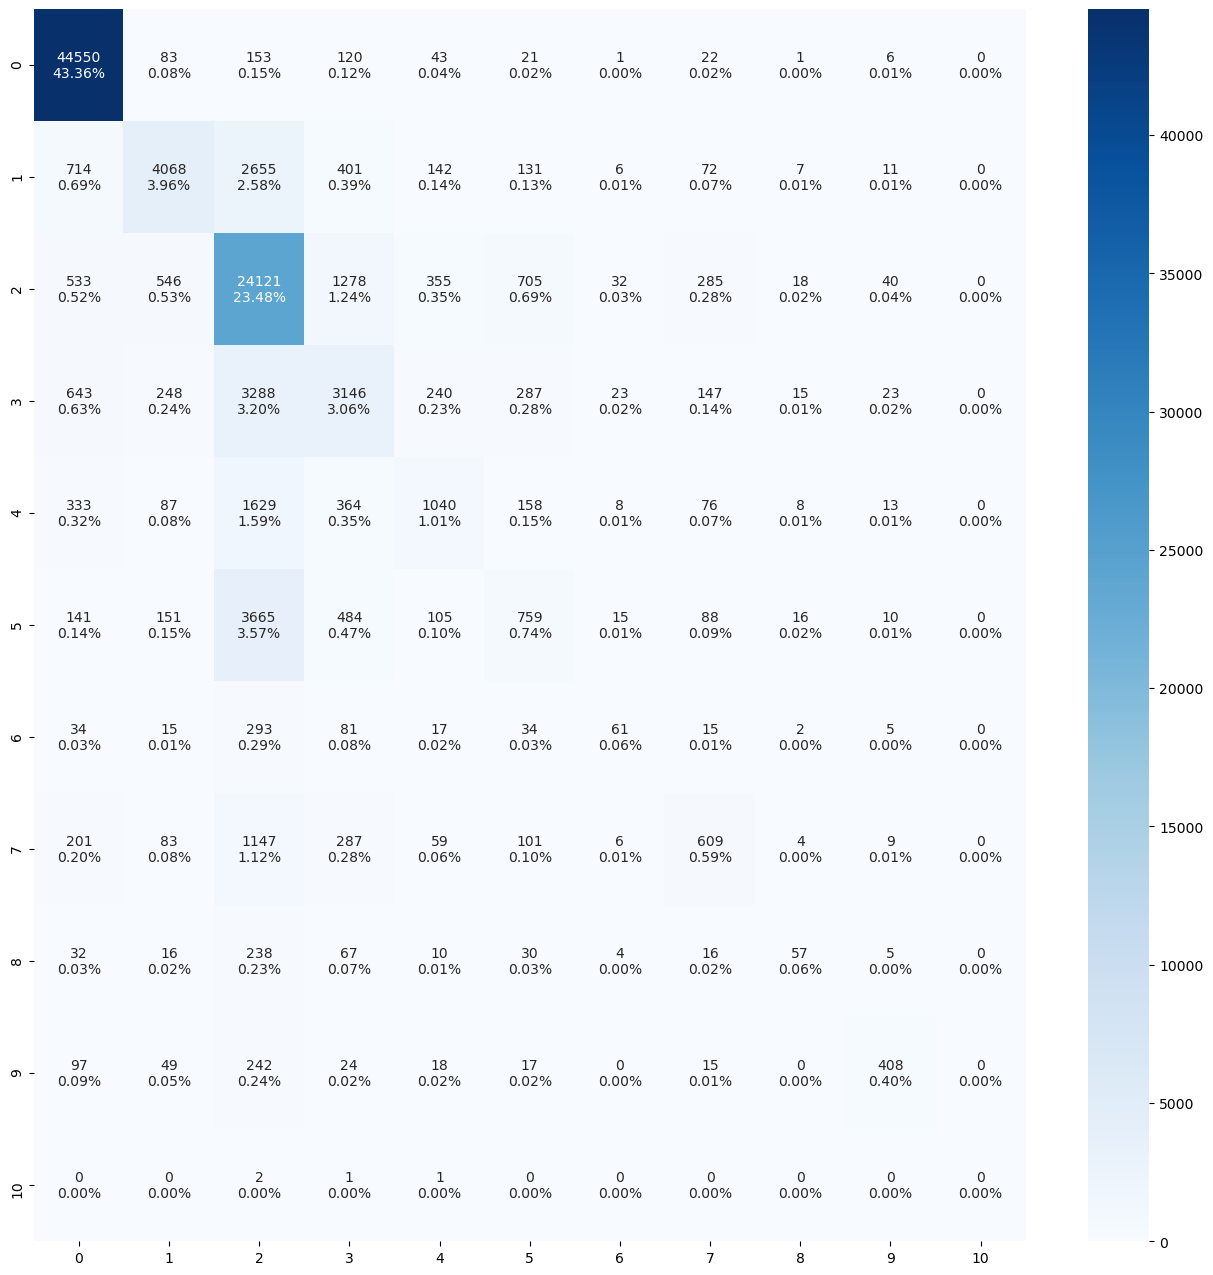

In [23]:
plot_confusion(cf_matrix)

In [24]:
pd.DataFrame({'feature_importance': model_cat.get_feature_importance(), 
              'feature_names': X_train_total.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
3,36.636300,Source_Encoding
4,23.935739,Target_Encoding
2,20.138445,visits
1,12.981935,time_spent
0,6.307581,hour


# Exporting to Gephi

In [25]:
# converting to gephi
preds = model_cat.predict(X_valid_total)
X_predicted_gephi = X_valid_gephi.copy()
X_predicted_gephi['y']=preds

X_predicted_gephi['Valid'] = 0
X_valid_gephi['Valid'] = 1
X_valid_gephi.head()

,venueid,hour,time_spent,visits,day,level1cat,Source_Encoding,Target_Encoding,y,Valid
0,4d08fffccda25481ef0b3065,11,10,2,28.0,Food,259,5351,5,1
1,4ae1ec77f964a520c98821e3,18,2028,58,NaN,No Colocation,8570,13099,0,1
2,512fcf95e4122e40ecc574e3,12,3215,57,NaN,No Colocation,4537,25904,0,1
3,4b9c0a03f964a520af4336e3,4,3307,55,NaN,No Colocation,5420,7665,0,1
4,4cb8971a23a4199c6ce0ec89,7,2876,55,NaN,No Colocation,17739,19688,0,1


In [27]:
X_venue_gephi = pd.concat([X_predicted_gephi, X_valid_gephi])
venues_graph = nx.from_pandas_edgelist(X_venue_gephi,source = 'Source_Encoding',target='Target_Encoding', edge_attr=list(X_venue_gephi.columns),create_using=nx.MultiGraph())
nx.write_gexf(venues_graph, 'graph_files/venue_graph.gexf')